<a href="https://colab.research.google.com/github/ctartist621/old-betsy/blob/develop/old_betsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is for the model to take:

1) Time
2) Transmit Grid Square

Output:
1) Most likely Grid Squares to contact
2) Which band to use
3) Which Mode to use

Label is: db

In [1]:
!pip install matplotlib>=3.5.1
!pip install torch>=1.11.0
!pip install torchtext>=0.12.0
!pip install pandas>=1.3.5
!pip install numpy>=1.21.0

In [4]:
from google.colab import drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torchtext.transforms import LabelToIndex
from typing import List


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
class DXDataset(Dataset):
    def __init__(self, file):
        self.data = pd.read_csv(file)

        # self.data = self.data.sample(frac=0.001)
        self.labels = self.data['callsign_grid'].unique()

        self.target_labels = {
            'dx_grid': self.data['dx_grid'].unique(),
            'band': self.data['band'].unique(),
            'mode': self.data['mode'].unique(),
            'tx_mode': self.data['tx_mode'].unique(),
        }

        self.transform = LabelToIndex(label_names=self.labels.tolist())
        self.target_transforms = {
            'dx_grid': LabelToIndex(label_names=self.target_labels['dx_grid'].tolist()),
            'band': LabelToIndex(label_names=self.target_labels['band'].tolist()),
            'mode': LabelToIndex(label_names=self.target_labels['mode'].tolist()),
            'tx_mode': LabelToIndex(label_names=self.target_labels['tx_mode'].tolist()),
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx].drop(["Unnamed: 0", "snr",'dx_grid','band','mode', 'tx_mode'])
        label = self.data.iloc[idx]

        data['callsign_grid'] = self.transform.forward(data['callsign_grid'])
        data = torch.FloatTensor(data)
        label = torch.FloatTensor([
            self.target_transforms['dx_grid'].forward(label['dx_grid']),
            self.target_transforms['band'].forward(label['band']),
            self.target_transforms['mode'].forward(label['mode']),
            self.target_transforms['tx_mode'].forward(label['tx_mode']),
        ])
        return data, label

In [10]:
training_data = DXDataset("/content/drive/Othercomputers/My MacBook Pro/old-betsy-data/train.csv")
test_data = DXDataset("/content/drive/Othercomputers/My MacBook Pro/old-betsy-data/test.csv")
print(len(training_data), len(test_data))

285077 71723


In [11]:
data, label = training_data.__getitem__(300)
label

tensor([44.,  2.,  0.,  0.])

In [12]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [13]:
train_features, train_labels = next(iter(train_dataloader))
train_features

tensor([[14., -1., -1.,  ...,  5., 42., 16.],
        [27., -1., -1.,  ..., 19., 49., 55.],
        [34., -1., -1.,  ..., 11., 53.,  1.],
        ...,
        [29., -1., -1.,  ..., 15., 16.,  1.],
        [29., -1., -1.,  ..., 17.,  4.,  9.],
        [ 8., -1., -1.,  ...,  6., 35., 49.]])

Feature batch shape: torch.Size([64, 51])
Labels batch shape: torch.Size([64, 4])


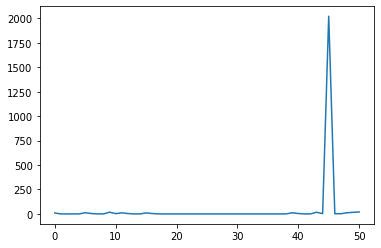

Label: tensor([1043.,    3.,    0.,    0.])


In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
input = train_features[0]
label = train_labels[0]
plt.plot(input)
plt.show()
print(f"Label: {label}")

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(training_data.__getitem__(0)[0]), 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, len(training_data.__getitem__(0)[1])),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [16]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [20]:
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=51, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [28]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X.to(device)
        y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [31]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X.to(device)
            y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            item_check = (pred.argmax(dim=0) == y)

            correct += (pred.argmax(dim=0) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= (size * y.numel())
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 29.583061  [    0/285077]
loss: 46.565880  [ 6400/285077]
loss: 21.332752  [12800/285077]
loss: 31.455881  [19200/285077]
loss: 36.284801  [25600/285077]
loss: 28.492590  [32000/285077]
loss: 46.040718  [38400/285077]
loss: 32.421875  [44800/285077]
loss: 29.235962  [51200/285077]


In [ ]:
test_loop(test_dataloader, model, loss_fn)
